# 06: 学習率スケジューリング (Learning Rate Scheduling)

このノートブックでは、ニューラルネットワークの学習性能をさらに向上させるための重要なテクニック、「学習率スケジューリング」について学びます。
学習率（Learning Rate, $\eta$）は、オプティマイザがどれくらいの歩幅でパラメータを更新するかを決定するハイパーパラメータであり、その値は学習の速度と最終的な性能に極めて大きな影響を与えます。

学習率スケジューリングは、この学習率を学習の進行に応じて動的に変化させる戦略です。なぜ固定の学習率では不十分なのか、そしてどのように学習率を変化させるのが効果的なのかを、代表的な手法（StepLR, ExponentialLR, CosineAnnealingLR）を通して理解します。

**参考論文:**
*   (Cosine Annealing) Loshchilov, I., & Hutter, F. (2016). SGDR: Stochastic Gradient Descent with Warm Restarts.

**このノートブックで学ぶこと:**
1.  なぜ学習率スケジューリングが必要なのか、固定学習率の課題。
2.  段階的に学習率を減衰させるStepLR。
3.  指数関数的に学習率を減衰させるExponentialLR。
4.  滑らかな余弦曲線に沿って学習率を変化させるCosineAnnealingLR。
5.  各スケジューラの挙動の可視化と、それが学習に与える影響の考察。
6.  学習初期に学習率を徐々に上げるウォームアップ（Warmup）の概念。

**前提知識:**
*   勾配降下法と学習率の役割についての理解。
*   オプティマイザ（特にSGDやAdam）の基本的な知識。
*   NumPyとMatplotlibの基本的な使い方。

## 1. 必要なライブラリのインポート

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math

## 2. なぜ学習率スケジューリングが必要か？

これまでのノートブックでは、学習率 $\eta$ を固定の値として扱ってきました。しかし、固定学習率にはいくつかの課題があります。

*   **学習率が大きすぎる場合**: 学習は速く進みますが、最適解の周辺で更新ステップが大きすぎて行ったり来たりと振動してしまい、うまく収束できない可能性があります。
*   **学習率が小さすぎる場合**: 学習は安定しますが、収束が非常に遅くなり、膨大な時間が必要になります。また、鞍点（saddle point）や浅い局所解から抜け出しにくくなることもあります。

**理想的な戦略**は、
1.  **学習の初期段階**では、比較的に**大きな学習率**を設定して、損失を大胆に減少させ、最適解の方向へ素早く進む。
2.  **学習の後期段階**では、最適解に近づいているため、**小さな学習率**に切り替えて、最適解の周りで細かく調整し、安定して収束させる。

この「学習の進行度に応じて学習率を動的に調整する」という考え方が、学習率スケジューリングの基本です。

## 3. 代表的な学習率スケジューラ

ここでは、代表的な3つの学習率スケジューラを実装し、その挙動を可視化します。
各スケジューラは、現在のエポック（またはステップ）数に基づいて、新しい学習率を計算します。

### 3.1 ステップ減衰 (StepLR)

StepLRは、最もシンプルで直感的なスケジューラです。一定のエポック数（`step_size`）ごとに、学習率に減衰率（`gamma`）を乗算して段階的に減少させます。

**更新式:**
エポック数が `step_size` の倍数になるたびに、
$$
\eta_{new} = \eta_{old} \times \gamma
$$
を実行します。ここで、$\gamma$ は通常1未満の値（例: 0.1, 0.5）です。

In [13]:
class StepLR:
    def __init__(self, initial_lr, step_size, gamma=0.1):
        self.lr = initial_lr
        self.step_size = step_size
        self.gamma = gamma
        self.last_epoch = 0

    def get_lr(self, epoch):
        if epoch == 0 or epoch % self.step_size != 0:
            return self.lr
        
        self.lr *= self.gamma
        return self.lr

### 3.2 指数関数的減衰 (ExponentialLR)

ExponentialLRは、エポックごとに学習率に一定の減衰率 `gamma` を乗算し、指数関数的に学習率を減少させます。StepLRよりも滑らかに学習率が変化します。

**更新式:**
毎エポック、
$$
\eta_{epoch} = \eta_{initial} \times \gamma^{epoch}
$$
または、
$$
\eta_{epoch} = \eta_{epoch-1} \times \gamma
$$
を実行します。

In [14]:
class ExponentialLR:
    def __init__(self, initial_lr, gamma=0.95):
        self.lr = initial_lr
        self.gamma = gamma

    def get_lr(self, epoch):
        return self.lr * (self.gamma ** epoch)

### 3.3 コサインアニーリング (CosineAnnealingLR)

CosineAnnealingLRは、より洗練されたスケジューラで、近年広く使われています。学習率を、余弦（コサイン）曲線に沿って滑らかに減少させます。

**更新式:**
$$
\eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min}) \left( 1 + \cos\left(\frac{T_{cur}}{T_{max}}\pi\right) \right)
$$

ここで、
*   $\eta_t$ は現在の学習率。
*   $\eta_{max}$ は初期（最大）学習率。
*   $\eta_{min}$ は最小学習率（通常は0に近い値）。
*   $T_{max}$ はスケジュールの周期（全エポック数など）。
*   $T_{cur}$ は現在のエポック数（$0 \le T_{cur} \le T_{max}$）。

**特徴:**
*   学習の初期はゆっくりと減少し、中盤で急速に減少し、終盤で再びゆっくりと減少するという、滑らかなカーブを描きます。
*   これにより、急激な学習率の変化による学習の不安定化を防ぎつつ、効率的に学習率を下げることができます。
*   SGDR (Stochastic Gradient Descent with Warm Restarts) という手法では、このコサインカーブを複数回繰り返すことで、局所解から脱出する効果も狙います。

In [15]:
class CosineAnnealingLR:
    def __init__(self, initial_lr, T_max, eta_min=0):
        self.initial_lr = initial_lr
        self.T_max = T_max
        self.eta_min = eta_min

    def get_lr(self, epoch):
        # epochがT_maxを超えた場合は、最小学習率を返す
        if epoch >= self.T_max:
            return self.eta_min
        
        return self.eta_min + 0.5 * (self.initial_lr - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max))

## 4. 各スケジューラの挙動の比較

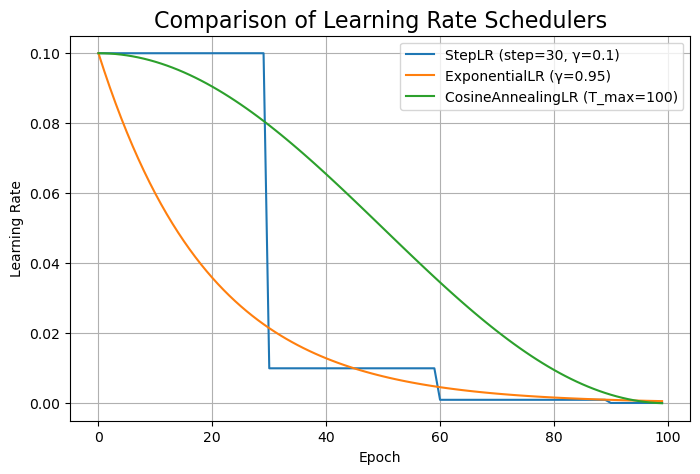

In [16]:
# パラメータ設定
initial_lr = 0.1
total_epochs = 100

# スケジューラのインスタンス化
schedulers = {
    "StepLR (step=30, γ=0.1)": StepLR(initial_lr, step_size=30, gamma=0.1),
    "ExponentialLR (γ=0.95)": ExponentialLR(initial_lr, gamma=0.95),
    "CosineAnnealingLR (T_max=100)": CosineAnnealingLR(initial_lr, T_max=total_epochs)
}

# 各エポックでの学習率を記録
lr_histories = {}
for name, scheduler in schedulers.items():
    history = []
    # StepLRは内部状態を持つため、get_lrを順に呼び出す
    if isinstance(scheduler, StepLR):
        for epoch in range(total_epochs):
            history.append(scheduler.get_lr(epoch))
    else:
        for epoch in range(total_epochs):
            history.append(scheduler.get_lr(epoch))
    lr_histories[name] = history

# グラフ描画
plt.figure(figsize=(8, 5))
for name, history in lr_histories.items():
    plt.plot(range(total_epochs), history, label=name)

plt.title("Comparison of Learning Rate Schedulers", fontsize=16)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.grid(True)
plt.show()

## 5. ウォームアップ (Warmup)

ウォームアップは、学習率スケジューリングと組み合わせて使われることが多いテクニックです。
学習の**最初の数エポック**において、学習率を小さな値から初期学習率まで**線形に増加**させます。

**なぜ必要か？**
学習の開始直後は、パラメータがランダムな値に初期化されているため、モデルは非常に不安定です。この状態でいきなり大きな学習率を適用すると、損失が発散してしまう可能性があります。
ウォームアップを行うことで、モデルが安定するまでの間、小さな更新ステップで優しく学習を進め、その後に本格的な学習（スケジューラによる減衰）に移行することができます。

これは、特にAdamのような適応的学習率を持つオプティマイザや、Transformerのような大規模モデルの学習を安定させるのに非常に効果的です。

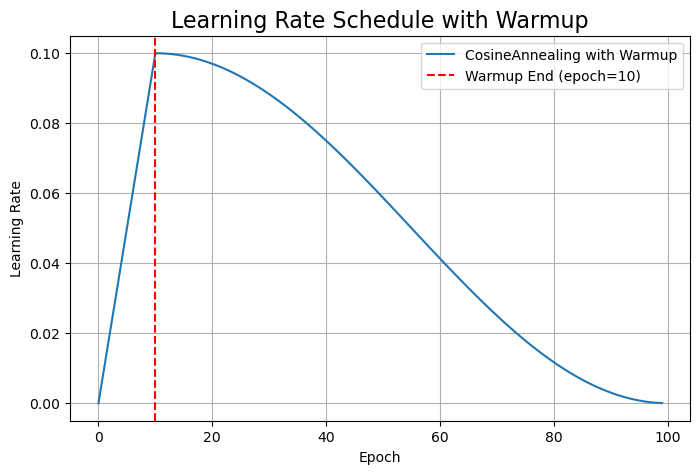

In [17]:
def warmup_and_cosine_annealing(epoch, warmup_epochs, total_epochs, initial_lr):
    if epoch < warmup_epochs:
        # ウォームアップ期間：線形に学習率を増加
        return initial_lr * (epoch / warmup_epochs)
    else:
        # コサインアニーリング期間
        # 新しいT_maxとT_curを計算
        T_max_new = total_epochs - warmup_epochs
        T_cur_new = epoch - warmup_epochs
        eta_min = 0
        
        return eta_min + 0.5 * (initial_lr - eta_min) * (1 + math.cos(math.pi * T_cur_new / T_max_new))

# パラメータ設定
initial_lr = 0.1
total_epochs = 100
warmup_epochs = 10

# 学習率の履歴を計算
warmup_history = [warmup_and_cosine_annealing(e, warmup_epochs, total_epochs, initial_lr) for e in range(total_epochs)]

# グラフ描画
plt.figure(figsize=(8, 5))
plt.plot(range(total_epochs), warmup_history, label="CosineAnnealing with Warmup")
plt.title("Learning Rate Schedule with Warmup", fontsize=16)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.axvline(x=warmup_epochs, color='r', linestyle='--', label=f"Warmup End (epoch={warmup_epochs})")
plt.legend()
plt.grid(True)
plt.show()

## 6. まとめと考察

このノートブックでは、学習率を動的に調整する様々なスケジューリング手法について学びました。

*   **StepLR**と**ExponentialLR**は、シンプルで実装も容易ですが、学習率の変化がやや場当たり的になる可能性があります。
*   **CosineAnnealingLR**は、滑らかな曲線で学習率を変化させることで、学習を安定させつつ効率的に収束させる、非常に強力な手法です。現在の多くの研究や実践で採用されています。
*   **ウォームアップ**は、学習初期の不安定さを乗り越え、特に大規模なモデルの学習を成功させるための重要な補助的テクニックです。

**実践的なガイドライン:**
*   どのスケジューラを使うべきか迷った場合、**ウォームアップ付きのコサインアニーリング**が、多くの場合でロバストで高性能な結果をもたらす良い出発点となります。
*   学習率スケジューラの導入は、最終的なモデルの精度をもう一段階引き上げるための重要なチューニングステップです。
*   ハイパーパラメータ（`step_size`, `gamma`, `T_max`など）の選択は、データセットやモデルのサイズ、総エポック数に依存するため、実験を通して調整する必要があります。

これまで学んできたオプティマイザと、このノートブックで学んだ学習率スケジューラを組み合わせることで、我々はニューラルネットワークの学習プロセスをより高度に制御する手段を手に入れたことになります。
